In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import torchvision
import torch
from torchvision import transforms
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import glob
import scipy.io
import pandas as pd
import shutil
import os
from numpy import *
from PIL import Image
from matplotlib import pyplot as plt

In [8]:
#функция для загрузки данных, разбиения на test,train,val и на батчи
def load_data(attribute):
    full_dataset = torchvision.datasets.ImageFolder(
        '/fin_df/'+attribute,
        transforms.ToTensor())
    train_size = int(0.8 * len(full_dataset))
    test_val_size = len(full_dataset) - train_size
    train_dataset, test_val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_val_size])
    test_size = int(0.5 * len(test_val_dataset))
    val_size = len(test_val_dataset) - test_size
    test_dataset, val_dataset = torch.utils.data.random_split(test_val_dataset, [test_size, val_size])
    batch_size = 32
    train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=2)


    val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=2)
    test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=2)
    return train_batch_gen,val_batch_gen,train_dataset,val_dataset,test_batch_gen,test_dataset

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [10]:
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False  

def new_seq(res):
    return nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3), #3 * 128 * 128 -> 8 126 126 
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),# 16 122 122
            
            nn.MaxPool2d(2),#16 61 61
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),#32 57 57
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3), # 32 55 55
            nn.MaxPool2d(4),
            nn.ReLU(),

            Flatten(),
            nn.Dropout(p = 0.3),
            nn.Linear(5408, 2048), #32 * 13 *13
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            
            nn.Linear(512, res),
            nn.LogSoftmax()
            
            )

In [11]:
def compute_loss(model,X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model.cuda()(X_batch)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits, y_batch)#.mean()

    return loss

In [12]:
#функция для тренировки и проверки точности на валидации
from torch.optim import Adam
from  tqdm import tqdm_notebook
import time
batch_size = 32

def train_and_val(model,train_batch_gen,val_batch_gen,train_dataset,val_dataset,attribute,test_batch_gen,test_dataset):
    opt = Adam(model.parameters(),
           lr = 1e-3,  
           weight_decay = 1e-4) 
    train_loss = []
    val_accuracy = []

    num_epochs = 30  
    max_val_accuracy = 0 
    counter = 0

    for epoch in tqdm_notebook(range(num_epochs)):
        start_time = time.time()
        model.train(True) 
        for (X_batch, y_batch) in train_batch_gen:
       
            counter = counter + 1
            loss = compute_loss(model,X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy())

        model.eval()
        for X_batch, y_batch in val_batch_gen:
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda()) 
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(train_dataset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

        if np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100 > max_val_accuracy:
            max_val_accuracy =  np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100
    test_acc(model,test_batch_gen,test_dataset)
    save_weight(model,attribute)



In [13]:
#cохраняю веса для каждого атрибута под его именем
def save_weight(model,fn):
    filename = fn
    torch.save(model.state_dict(),filename)
    

In [14]:
def test_acc(model,test_batch_gen,test_dataset):
    test_accuracy =[]
    for X_batch, y_batch in test_batch_gen:
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda()) 
            y_pred = logits.max(1)[1].data
            test_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    print("test accuracy: \t\t\t{:.2f} %".format(
        np.mean(test_accuracy[-len(test_dataset) // batch_size :]) * 100))


In [18]:
attributes = ['category']

In [ ]:
train_batch_gen,val_batch_gen,train_dataset,val_dataset,test_batch_gen,test_dataset = load_data(attributes[0])
category = new_seq(8)

train_and_val(category,train_batch_gen,val_batch_gen,train_dataset,val_dataset,attributes[0],test_batch_gen,test_dataset)


In [45]:
#функция для предсказания значений определенного атрибута одежды, размер изображения изменен заранее на 128 х 128
def predict(model):

    column = []
    for i in all_images_list:
 
        img_r = i.reshape([1, 128, 128, 3]).transpose([0, 3, 1, 2])
        res = (model(Variable(torch.FloatTensor(img_r)).cuda())).max(1)[1].data
        column.append(int(res))

        
    return column


In [35]:
#list of images 
all_images_list = []
imagenames_inst = glob.glob('/insta_df/images/*.jpeg')
imagelist_inst = []
for st in imagenames_inst:
    imagelist_inst.append(st[st.rindex('\\')+1 :-5])
for i in imagenames_inst :   
    img = np.array(Image.open(i))/255.0
    all_images_list.append(img)   

In [297]:
df_result['inames'] = imagelist_inst

In [111]:
category = new_seq(8)
category.load_state_dict(torch.load('category'))
category.eval().cuda()

predict(category)

tensor([7], device='cuda:0')

In [19]:
path = '/fin_df/'
dirs = os.listdir(path)
for i in dirs:
    if i != 'category':
        attributes.append(i)

    

In [17]:
attributes

['category',
 'black',
 'blue',
 'brown',
 'collar',
 'cyan',
 'gray',
 'green',
 'many_colors',
 'neckline',
 'necktie',
 'pattern_floral',
 'pattern_graphics',
 'pattern_plaid',
 'pattern_solid',
 'pattern_spot',
 'pattern_stripe',
 'placket',
 'purple',
 'red',
 'scarf',
 'sleevelength',
 'white',
 'yellow']

In [ ]:
#attributes
for i in attributes:
    if i != 'category':
        o = len(os.listdir(path+i))
        train_batch_gen,val_batch_gen,train_dataset,val_dataset,test_batch_gen,test_dataset = load_data(i)
        model = new_seq(o)

        train_and_val(model,train_batch_gen,val_batch_gen,train_dataset,val_dataset,i,test_batch_gen,test_dataset)

        

In [296]:
df_result = pd.DataFrame()

In [298]:
Sleeves =  ['No sleeves','Short sleeves','Long sleeves']
Neckline=[ 'V-shape','Round', 'Other shapes']
Category= ['Shirt', 'Sweater', 'T-shirt', 'Outerwear', 'Suit', 'Tank Top',' Dress']



for i in attributes:
    
    out = len(os.listdir(path+i))
    #print(i)
    attr = new_seq(out)
    
    attr.load_state_dict(torch.load(i))
    attr.eval().cuda()

    res = predict(attr)
    df_result[i] = res
    
    #if res > 0:
    #    if i == 'neckline':
    #        print(i,Neckline[res-1])
    #    elif  i == 'category':
    #        print(i,Category[res-1])
    #   elif  i == 'sleevelength':
    #        print(i,Sleeves[res-1])
    #    else:
    #        print(i)
            
            
        

In [124]:
df_result.head(10)

,category,black,blue,brown,collar,cyan,gray,green,many_colors,neckline,...,pattern_solid,pattern_spot,pattern_stripe,placket,purple,red,scarf,sleevelength,white,yellow
0,0,0,0,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,1,0,0
1,7,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,2,1,0
2,0,1,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,3,0,0
3,7,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,3,0,0
5,6,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,3,1,0
6,0,0,0,0,0,0,0,1,0,2,...,1,0,0,0,0,0,0,3,0,0
7,7,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,2,1,0
8,7,0,0,0,0,0,0,0,1,2,...,1,0,0,0,0,0,0,3,0,0
9,7,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2,0,0


In [125]:
#df_result.to_csv(r'insta_attributies.csv', index = False, header=True)

In [126]:
df_likes = pd.read_csv('/insta_df/labels.csv', sep=',', names = ['inames','likes'],engine='python'  )

In [299]:
df_result = df_result.merge(df_likes, how='left')

In [300]:
df_result

,inames,category,black,blue,brown,collar,cyan,gray,green,many_colors,...,pattern_spot,pattern_stripe,placket,purple,red,scarf,sleevelength,white,yellow,likes
0,B-B7ZmcB69V,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,55183
1,B-CybjtBncX,7,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,2,1,0,85874
2,B-eH3PLhDT9,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,3,0,0,80040
3,B-FdbdJhxln,7,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,2,0,0,46407
4,B-gwHt6hH2u,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,200068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,BZY9HKCghPg,3,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,3,0,0,147249
1910,BZylmgMgOip,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,110655
1911,BzzsWC2CApy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,216156
1912,BzZ_FgWC8_S,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,3,0,0,103979


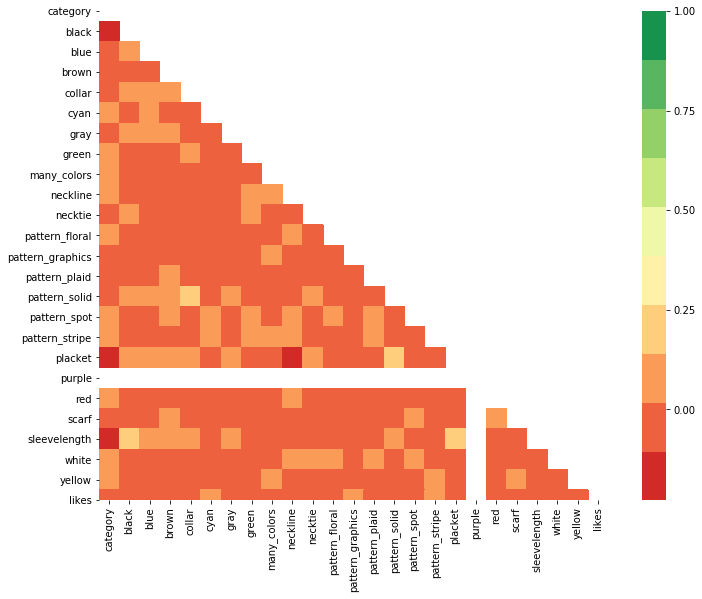

In [303]:
import seaborn as sns
corrmat = df_result.corr()
f, ax = plt.subplots(figsize=(12, 9))
cmap = sns.color_palette("RdYlGn", 10)
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrmat,cmap=cmap,  square=True,mask=mask)

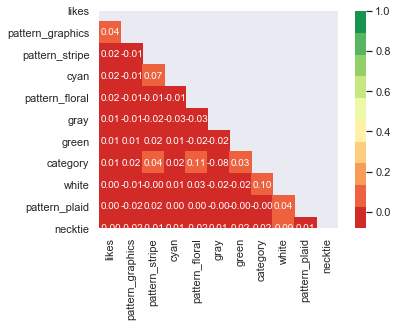

In [305]:
k = 11
cols = corrmat.nlargest(k, 'likes')['likes'].index
cm = np.corrcoef(df_result[cols].values.T)
sns.set(font_scale=1.0)
cmap = sns.color_palette("RdYlGn", 10)
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, mask = mask, cmap= cmap)
plt.show()

In [ ]:
# признаки почти не коррелируют с целевым
# это можно заметить и по результатам регресии

In [131]:


y = df_result['likes']
del df_result['likes']
del df_result['inames']
X = df_result

In [217]:
categ_X = X[['category','neckline','sleevelength']]

In [218]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(categ_X)
columns = enc.get_feature_names(categ_X.columns.tolist())

new_X = pd.DataFrame(enc.transform(categ_X).toarray(),columns = columns)


In [222]:
del X['category']
del X['neckline']
del X['sleevelength']

for i in new_X.columns.tolist():
    X[i] = new_X[i]

In [231]:
for i in X.columns:
    X[i] = X[i].astype('float') 

In [265]:
 X

,black,blue,brown,collar,cyan,gray,green,many_colors,necktie,pattern_floral,...,category_6,category_7,neckline_0,neckline_1,neckline_2,neckline_3,sleevelength_0,sleevelength_1,sleevelength_2,sleevelength_3
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1912,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [226]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [233]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [266]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [268]:

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                    max_depth = 5, n_estimators = 10,min_child_weight=5)
    xg_reg.fit(X_train,y_train)

    preds = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))

RMSE: 0.061228


In [146]:
#нормируем лайки приведя их к шкале от 0 до 1 (так будет нагляднеее)

In [177]:
max_like = y.dropna().max()
min_like = y.dropna().min()

In [148]:
y = (y - min_like)/(max_like - min_like)

In [247]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42)

In [248]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.060462


In [249]:
def predict_new_image(model, im_list):

    column = []
    for i in im_list:

        img = np.array(Image.open(i).resize((128,128)))/255.0
        
        img_r = img.reshape([1, 128, 128, 3]).transpose([0, 3, 1, 2])
        res = (model(Variable(torch.FloatTensor(img_r)).cuda())).max(1)[1].data
        column.append(int(res))

        
    return column

In [288]:
# likes prediction for random outfits

im_list = [im0,im1,im2,im3]
df_topredict = pd.DataFrame()

for i in attributes:
    
    out = len(os.listdir(path+i))
    attr = new_seq(out)
    
    attr.load_state_dict(torch.load(i))
    attr.eval().cuda()

    res = predict_new_image(attr,im_list)
    df_topredict[i] = res
    
    #if res > 0:
    #    if i == 'neckline':
    #        print(i,Neckline[res-1])
    #    elif  i == 'category':
    #        print(i,Category[res-1])
    #   elif  i == 'sleevelength':
    #        print(i,Sleeves[res-1])
    #    else:
    #        print(i)
#

In [289]:
df_topredict

,category,black,blue,brown,collar,cyan,gray,green,many_colors,neckline,...,pattern_solid,pattern_spot,pattern_stripe,placket,purple,red,scarf,sleevelength,white,yellow
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,3,0,0
1,3,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,1,3,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,3,0,0
3,7,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3,0,0


In [290]:
categ_X = df_topredict[['category','neckline','sleevelength']]

In [291]:
one_hot = pd.DataFrame(enc.transform(categ_X).toarray(),columns = columns)
one_hot

,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,neckline_0,neckline_1,neckline_2,neckline_3,sleevelength_0,sleevelength_1,sleevelength_2,sleevelength_3
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [292]:
del df_topredict['category']
del df_topredict['neckline']
del df_topredict['sleevelength']

for i in one_hot.columns.tolist():
    df_topredict[i] = one_hot[i]

In [293]:
for i in df_topredict.columns:
    df_topredict[i] =df_topredict[i].astype('float') 

In [294]:
preds = xg_reg.predict(df_topredict)


In [295]:
preds

array([0.10244045, 0.10419595, 0.10194209, 0.10171846], dtype=float32)

In [23]:
#тут перечислена точность классификаторов моделей на тесте
dict_accuracy = {}
for i in attributes:
    train_batch_gen,val_batch_gen,train_dataset,val_dataset,test_batch_gen,test_dataset = load_data(i)
    out = len(os.listdir(path+i))
    attr = new_seq(out)
    
    attr.load_state_dict(torch.load(i))
    attr.eval().cuda()

    
    test_accuracy =[]
    for X_batch, y_batch in test_batch_gen:
        logits = attr(Variable(torch.FloatTensor(X_batch)).cuda())  #model(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        test_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
        
    dict_accuracy[i] = np.mean(test_accuracy[-len(test_dataset) // batch_size :]) * 100

<BarContainer object of 24 artists>

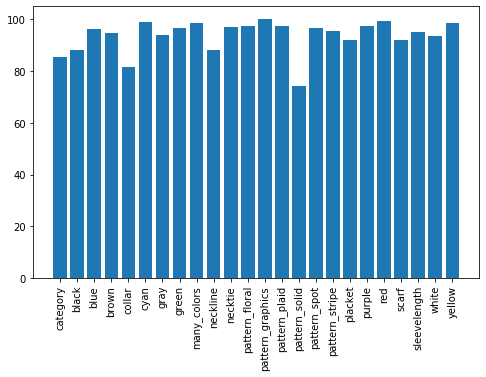

In [36]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=90) 
plt.bar(
    dict_accuracy.keys(), dict_accuracy.values()
)


In [37]:
dict_accuracy

{'category': 85.45673076923076,
 'black': 88.30128205128206,
 'blue': 96.11378205128206,
 'brown': 94.67147435897436,
 'collar': 81.41025641025642,
 'cyan': 98.83814102564102,
 'gray': 93.75,
 'green': 96.7548076923077,
 'many_colors': 98.4375,
 'neckline': 88.06089743589743,
 'necktie': 96.875,
 'pattern_floral': 97.39583333333334,
 'pattern_graphics': 100.0,
 'pattern_plaid': 97.39583333333334,
 'pattern_solid': 74.27884615384616,
 'pattern_spot': 96.7548076923077,
 'pattern_stripe': 95.3125,
 'placket': 91.94711538461539,
 'purple': 97.39583333333334,
 'red': 99.35897435897436,
 'scarf': 92.1875,
 'sleevelength': 95.07211538461539,
 'white': 93.38942307692308,
 'yellow': 98.4375}